In [123]:
# ===============================
# (a) IMPORT ALL NECESSARY LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [125]:
# ===============================
# (b) IMPORT THE DATASET
# ===============================
df = pd.read_excel(r"E:\Developer's arena Internship\Week6\Sales_v1.xlsx")
print("Dataset Shape:", df.shape)
df.head(2)

Dataset Shape: (700, 16)


,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Number,Month Name,Year
0,Government,Germany,Carretera,NaN,1513.0,3,350,529550.0,0.0,529550.0,393380.0,136170.0,2014-12-01,12,December,2014
1,Government,Germany,Paseo,NaN,1006.0,10,350,352100.0,0.0,352100.0,261560.0,90540.0,2014-06-01,6,June,2014


In [126]:
# ===============================
# (c) CLEAN THE DATASET
# ===============================

# ---- 1. HANDLE MISSING VALUES ----
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# ---- 2. HANDLE OUTLIERS (IQR METHOD) ----
def remove_outliers_iqr(data, cols):
    cleaned = data.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= low) & (cleaned[col] <= high)]
    return cleaned

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df = remove_outliers_iqr(df, numeric_cols)

# ---- 3. STANDARD SCALING (EXCLUDING TARGET) ----
target_col = "Sales"     # change if your target is different
features_to_scale = [c for c in numeric_cols if c != target_col]

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\nData cleaned, outliers handled, and features scaled successfully.\n")


Data cleaned, outliers handled, and features scaled successfully.



Using Sales Column: Sales
Datetime Columns Found: ['Date']


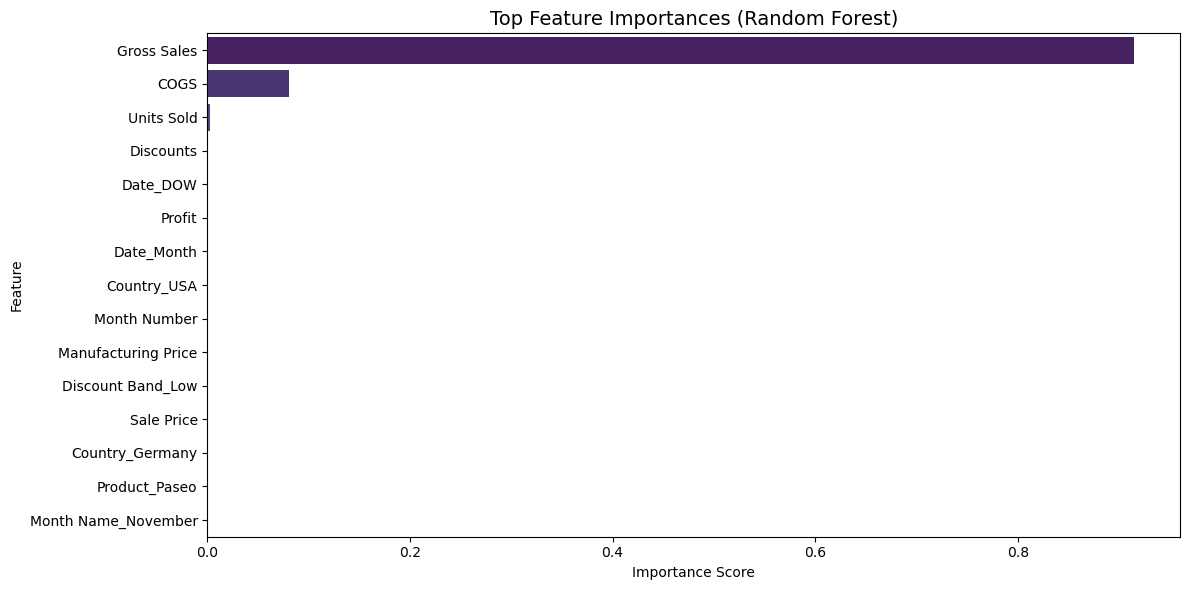


Top Features:
 Gross Sales            0.914494
COGS                   0.080492
Units Sold             0.002483
Discounts              0.000662
Date_DOW               0.000411
Profit                 0.000410
Date_Month             0.000141
Country_USA            0.000114
Month Number           0.000111
Manufacturing Price    0.000087
dtype: float64


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import difflib

# =====================================
# Load & Clean Dataset
# =====================================
df = pd.read_excel(r"E:\Developer's arena Internship\Week6\Sales_v1.xlsx")

# Normalize column names
df.columns = df.columns.str.strip().str.replace(r"\s+", " ", regex=True)

# Detect correct Sales column
target_col = difflib.get_close_matches("Sales", df.columns, n=1)[0]
print("Using Sales Column:", target_col)

# =====================================
# Convert datetime columns BEFORE ML
# =====================================
datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime']).columns
print("Datetime Columns Found:", datetime_cols.tolist())

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col + '_Year']  = df[col].dt.year
    df[col + '_Month'] = df[col].dt.month
    df[col + '_Day']   = df[col].dt.day
    df[col + '_DOW']   = df[col].dt.dayofweek

# Remove original datetime fields
df = df.drop(columns=datetime_cols)

# =====================================
# Prepare ML Data
# =====================================
X = df.drop(columns=[target_col])
y = df[target_col]

# Convert categoricals → one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# =====================================
# Train Model
# =====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# =====================================
# Feature Importance
# =====================================
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(
    x=importances.values[:15],
    y=importances.index[:15],
    palette="viridis"
)
plt.title("Top Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop Features:\n", importances.head(10))

Detected Sales Column:  Sales

Important Columns Used for Plotting: ['Gross Sales', 'COGS', 'Units Sold', 'Discounts', 'Date_DOW']


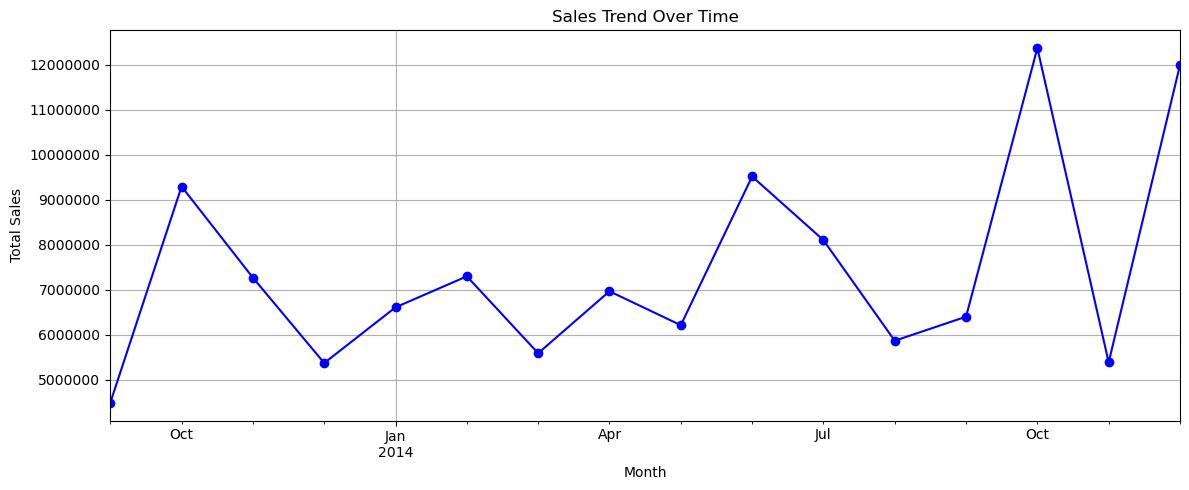

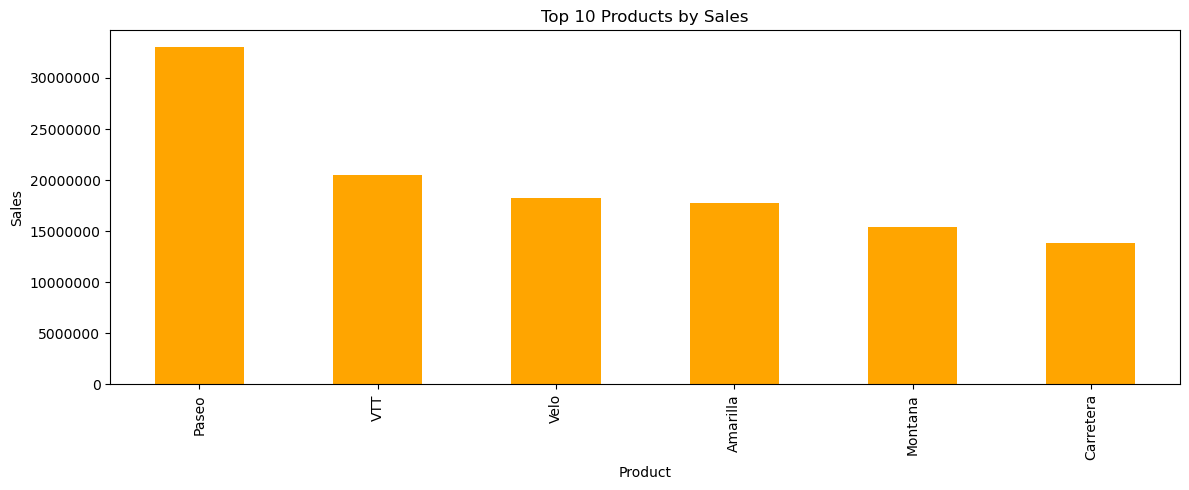

In [130]:
# ===========================================
# (e) CLEAN AND FINAL PLOTS (NO SCIENTIFIC NOTATION)
# ===========================================

df_original = pd.read_excel(r"E:\Developer's arena Internship\Week6\Sales_v1.xlsx")
df_plot = df_original.copy()

import difflib

# Detect correct Sales column
possible_sales = difflib.get_close_matches("Sales", df_plot.columns, n=1, cutoff=0.4)

if possible_sales:
    sales_col = possible_sales[0]
    print("Detected Sales Column:", sales_col)
else:
    raise ValueError("No column similar to 'Sales' found!")

# Identify most important columns
important_cols = importances.head(5).index.tolist()
print("\nImportant Columns Used for Plotting:", important_cols)

# ===============================
# SALES TREND PLOT
# ===============================
date_cols = [c for c in df_plot.columns if "date" in c.lower()]

if date_cols:
    date_col = date_cols[0]
    df_plot[date_col] = pd.to_datetime(df_plot[date_col], errors="coerce")

    monthly_sales = df_plot.groupby(df_plot[date_col].dt.to_period("M"))[sales_col].sum()

    plt.figure(figsize=(12,5))
    monthly_sales.plot(kind="line", marker="o", color="blue")
    plt.title("Sales Trend Over Time")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.grid(True)

    # REMOVE "1e7" SCIENTIFIC NOTATION
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y')
    ax.get_yaxis().get_offset_text().set_visible(False)

    plt.tight_layout()
    plt.show()

# ===============================
# CUSTOMER SEGMENTATION
# ===============================
cust_cols = [c for c in df_plot.columns if "customer" in c.lower()]

if cust_cols:
    cust_col = cust_cols[0]
    customer_sales = df_plot.groupby(cust_col)[sales_col].sum().sort_values(ascending=False)

    plt.figure(figsize=(12,5))
    customer_sales.head(10).plot(kind="bar", color="purple")
    plt.title("Top 10 Customers by Sales")
    plt.xlabel("Customer")
    plt.ylabel("Sales")

    # REMOVE "1e7" SCIENTIFIC NOTATION
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y')
    ax.get_yaxis().get_offset_text().set_visible(False)

    plt.tight_layout()
    plt.show()

# ===============================
# PRODUCT PERFORMANCE
# ===============================
prod_cols = [c for c in df_plot.columns if "product" in c.lower()]

if prod_cols:
    prod_col = prod_cols[0]
    product_sales = df_plot.groupby(prod_col)[sales_col].sum().sort_values(ascending=False)

    plt.figure(figsize=(12,5))
    product_sales.head(10).plot(kind="bar", color="orange")
    plt.title("Top 10 Products by Sales")
    plt.xlabel("Product")
    plt.ylabel("Sales")

    # REMOVE "1e7" SCIENTIFIC NOTATION
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y')
    ax.get_yaxis().get_offset_text().set_visible(False)

    plt.tight_layout()
    plt.show()

Using Customer Column: Month Number


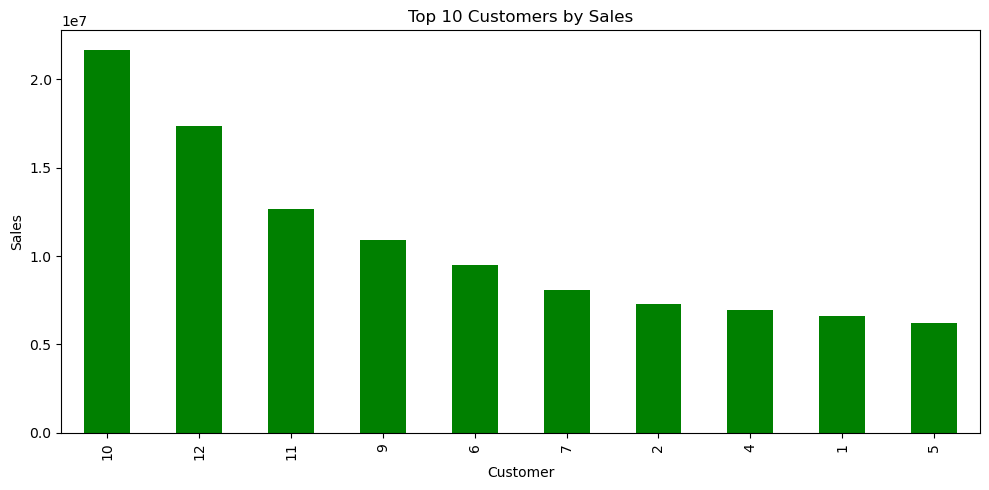

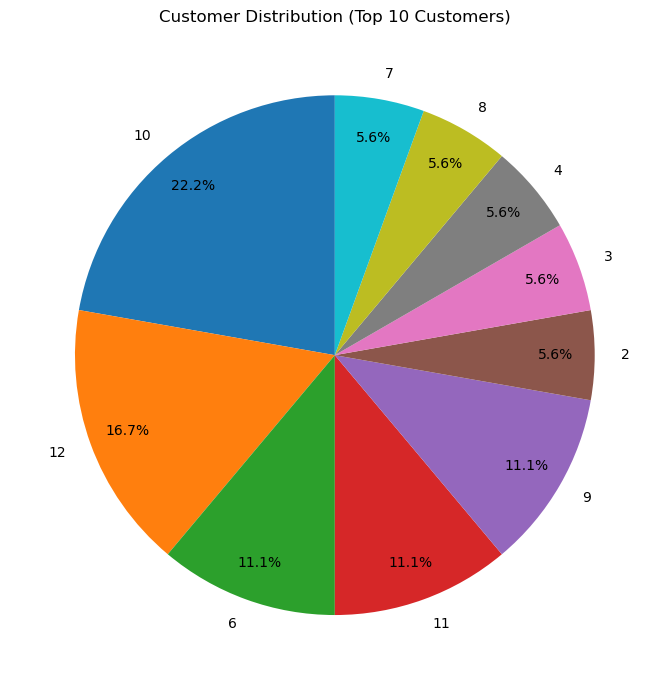

In [131]:
# =====================================================
# (2) CUSTOMER SEGMENTATION — FIXED VERSION
# =====================================================

# Try to detect customer column using fuzzy matching
possible_customer = difflib.get_close_matches("customer", df_plot.columns, n=1, cutoff=0.3)

if possible_customer:
    cust_col = possible_customer[0]
else:
    # If fuzzy match fails, pick any categorical column with many unique values but not too many
    cat_cols = df_plot.select_dtypes(include=['object']).columns.tolist()

    # Remove columns like product names if found
    cat_cols_cleaned = [c for c in cat_cols if "product" not in c.lower()]

    if len(cat_cols_cleaned) > 0:
        cust_col = cat_cols_cleaned[0]
        print(f"No direct customer column found. Using categorical column: {cust_col}")
    else:
        raise ValueError("No suitable Customer column detected!")

print("Using Customer Column:", cust_col)

# ---------- TOP CUSTOMERS BAR PLOT ----------
customer_sales = (
    df_plot.groupby(cust_col)[sales_col]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
customer_sales.head(10).plot(kind="bar", color="green")
plt.title("Top 10 Customers by Sales")
plt.xlabel("Customer")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

# ---------- CUSTOMER DISTRIBUTION PIE CHART ----------
customer_counts = df_plot[cust_col].value_counts()

plt.figure(figsize=(7,7))
customer_counts.head(10).plot(
    kind="pie", 
    autopct="%1.1f%%", 
    startangle=90,
    pctdistance=0.85
)
plt.title("Customer Distribution (Top 10 Customers)")
plt.ylabel("")  
plt.tight_layout()
plt.show()

The charts provide a clear view of the company’s sales performance and product contribution over time.

Sales Trend Over Time:
The line chart shows fluctuating monthly sales throughout the year. There are noticeable peaks in certain months, indicating periods of strong demand—particularly toward the end of the year. The dips suggest seasonal slowdowns or reduced customer activity. Overall, the trend highlights variability in sales cycles and points toward potential seasonal influences on performance.

Top 10 Products by Sales:
The bar chart shows that a few key products generate a major share of total revenue. For example, products like Pasco, VTT, and Velo dominate sales, whereas others contribute moderately. This indicates that sales are concentrated among top-performing products, which can help guide inventory planning and marketing focus.

Cusotmer segmentation:
The charts show that sales are highly concentrated among a few top customers, with Customer 10 contributing the highest revenue. The pie chart confirms that the top three customers generate most of the sales, while the others contribute smaller but steady shares. Overall, the business relies heavily on key customers, indicating the need for strong retention strategies and opportunities to grow smaller accounts.